In [1]:
# Imports
import tensorflow as tf
from tensorflow import keras
from keras import layers
import datetime
%load_ext tensorboard

In [2]:
# Model Configuration
image_size = (299,299)
batch_size = 32

train_ds = keras.preprocessing.image_dataset_from_directory(
    "Images",
    validation_split=0.2,
    subset="training",
    seed=1994,
    image_size=image_size,
    batch_size=batch_size,
)
test_ds = keras.preprocessing.image_dataset_from_directory(
    "Images",
    validation_split=0.2,
    subset="validation",
    seed=1994,
    image_size=image_size,
    batch_size=batch_size,
)

labels = test_ds.class_names
input_shape = image_size + (3,)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


In [3]:
# Augmentation Layers
data_augmentation = keras.models.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.Rescaling(1.0/255),
    ],
    name="Data_Augmentation"
)

In [4]:
# Prefetch Datasets in batches
train_ds = train_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)

In [5]:
# Define Base Model
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
input_shape=input_shape,
include_top=False)

base_model.trainable = False # Fix pretrained layers

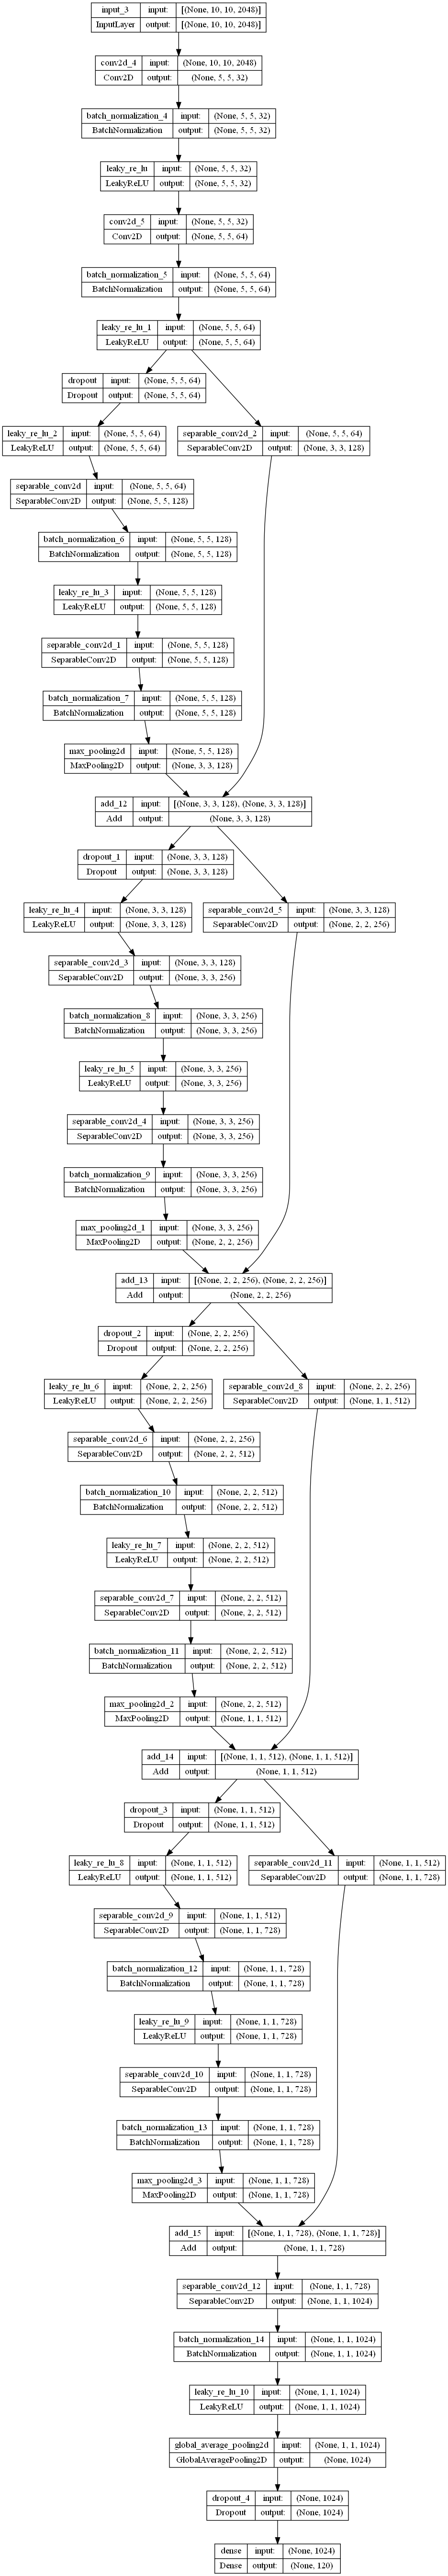

In [6]:
# Mini Xception ML Model
def make_model(inputs, num_classes):
    x=inputs


    # Entry flow
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.3)(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.3)(x)

    # First Residual
    previous_block_activation = x  

    # Increasing levels of Conv2D as in the entry flow of Xception
    for size in [128, 256, 512, 728]:
        x = layers.Dropout(0.05)(x)
        x = layers.LeakyReLU(alpha=0.3)(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.LeakyReLU(alpha=0.3)(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.SeparableConv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add residual from previous level
        previous_block_activation = x  # Set aside new residual

    # Middle flow at 1024x1024. Repeating only 3 times and not 8
    # for times in range(3):
    #     x = layers.Activation("relu")(x)
    #     x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    #     x = layers.BatchNormalization()(x)
    #     x = layers.Activation("relu")(x)
    #     x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    #     x = layers.BatchNormalization()(x)
    #     x = layers.MaxPooling2D(3, strides=2, padding="same")(x)


    # Exit flow (Simplified)
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs, name="My_Mini_Xception_Model")

my_model = make_model(inputs=base_model.output, num_classes=120)
my_model.trainable=True
keras.utils.plot_model(my_model, to_file="model_images/My_Model.png", show_shapes=True)

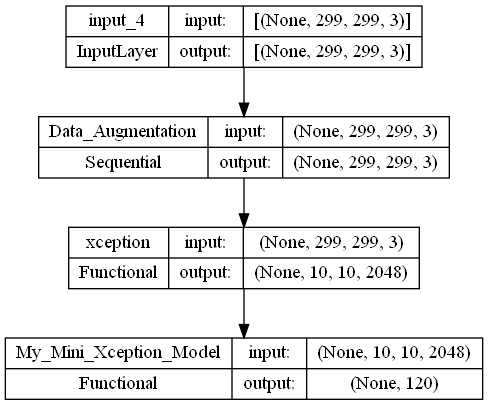

In [7]:
# Make Final Model
model = keras.models.Sequential([
    keras.Input(shape=input_shape),
    data_augmentation,
    base_model,
    my_model
    ])
keras.utils.plot_model(model,to_file="model_images/Model_Summary.png", show_shapes=True)

In [8]:
epochs = 15

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='./models/breed_classifier_model.h5', save_best_only=True),
    tf.keras.callbacks.ModelCheckpoint(filepath='./checkpoints/model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,profile_batch=(10, 15)),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=test_ds,
)


Epoch 1/15
515/515 [==============================] - 269s 501ms/step - loss: 2.2821 - accuracy: 0.3808 - val_loss: 2.3330 - val_accuracy: 0.5318
Epoch 2/15
515/515 [==============================] - 253s 491ms/step - loss: 1.3108 - accuracy: 0.6158 - val_loss: 0.8651 - val_accuracy: 0.7510
Epoch 3/15
515/515 [==============================] - 253s 491ms/step - loss: 1.0885 - accuracy: 0.6885 - val_loss: 0.8363 - val_accuracy: 0.7607
Epoch 4/15
515/515 [==============================] - 199s 387ms/step - loss: 0.9580 - accuracy: 0.7274 - val_loss: 0.6992 - val_accuracy: 0.8020
Epoch 5/15
515/515 [==============================] - 196s 381ms/step - loss: 0.8767 - accuracy: 0.7427 - val_loss: 0.6190 - val_accuracy: 0.8139
Epoch 6/15
515/515 [==============================] - 196s 380ms/step - loss: 0.8170 - accuracy: 0.7597 - val_loss: 0.6121 - val_accuracy: 0.8205
Epoch 7/15
515/515 [==============================] - 196s 380ms/step - loss: 0.7792 - accuracy: 0.7768 - val_loss: 0.6055 -

In [9]:
%tensorboard --logdir logs/fit

In [15]:
# Load from local
saved_model = keras.models.load_model('./models/breed_classifier_model.h5')


In [18]:
# Prediction test

# Load image
img = keras.preprocessing.image.load_img(
    "tests/1.jpg", target_size=image_size
)
# Convert input to array
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

In [19]:
# Predict Result
predictions = saved_model.predict(img_array)
result = predictions.argmax()
restype = labels[result]
print(
    f"This is an image of a {restype}"
)

1/1 [==============================] - 0s 28ms/step
This is an image of a Chihuahua
